In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [32]:
def sensitivityPlot(EXP, data_type, forecasting_horizon):
    best = pd.DataFrame(columns = ('data_type', 'forecasting_horizon', 'normalization', 'traj',
                                   'seq_len', 'img_size', 'trial_no', 'epoch', 
                                   'val_mape', 'val_mae', 'val_rmse', 'test_mape', 'test_mae', 'test_rmse', 'train_time'))
    
    i = 0
    
    for EXP_NO in EXP:
        log_files = os.listdir('log/' + EXP_NO + '/')
        all_logs = [files for files in log_files]

        for dataType in data_type:
            EXP = str(forecasting_horizon) + 'hours_dataType' + str(dataType)
            print len([f for f in all_logs if f.startswith(EXP)])
            for f in [f for f in all_logs if f.startswith(EXP)]:
                log_result = pd.read_csv('log/' + EXP_NO + '/' + f, index_col=0)

                if 'img0' in f.split('_'):
                    img_size = 0
                elif 'img3' in f.split('_'):
                    img_size = 3
                elif 'img11' in f.split('_'):
                    img_size = 11
                elif 'img21' in f.split('_'):
                    img_size = 21
                elif 'img41' in f.split('_'):
                    img_size = 41

                if 'seq6' in f.split('_'):
                    seq_len = 6
                elif 'seq12' in f.split('_'):
                    seq_len = 12
                elif 'seq24' in f.split('_'):
                    seq_len = 24
                    
                
                if 'normalization0' in f.split('_'):
                    norm = 'simple_const'
                elif ('normalization1' in f.split('_')) & ('clipped' in f.split('_')):
                    norm = 'spdLimit_1_clipped'
                elif 'normalization1' in f.split('_'):
                    norm = 'spdLimit_1'
                elif ('normalization2' in f.split('_')) & ('clipped' in f.split('_')):
                    norm = 'spdLimit_2_clipped'    
                elif 'normalization2' in f.split('_'):
                    norm = 'spdLimit_2'
                elif 'normalizationraw' in f.split('_'):
                    norm = 'raw'
                        
                if 'trajall' in f.split('_'):
                    traj = 'all'
                else:
                    traj = 'known'
                    
                best.loc[i] = [dataType, forecasting_horizon, 
                               norm, traj, seq_len, img_size, 0] + log_result.loc[log_result['val_mape'].idxmin()].values.tolist()

                i += 1
                
    result = best.loc[best.groupby(['data_type', 'forecasting_horizon', 'normalization', 'traj', 'img_size', 
                                    'seq_len'])['val_mape'].idxmin()][['data_type', 
                                                                       'forecasting_horizon', 'normalization', 'traj', 
                                                                       'seq_len', 'img_size', 'epoch', 
                                                                       'test_rmse', 'test_mae', 'test_mape']].reset_index()
    
    conditions_1 = [(result['normalization'] == 'raw'), (result['normalization'] == 'simple_const'),
                   (result['normalization'] == 'spdLimit_1'), (result['normalization'] == 'spdLimit_1_clipped'),
                   (result['normalization'] == 'spdLimit_2'), (result['normalization'] == 'spdLimit_2_clipped')]
    conditions_2 = [(result['traj'] == 'all'), (result['traj'] == 'known')]
    choices_1 = [0, 1, 2, 3, 4, 5]
    choices_2 = [0, 1]
    
    result['norm_idx'] = np.select(conditions_1, choices_1, default=9)
    result['traj_idx'] = np.select(conditions_2, choices_2, default=9)    
    
    p = np.zeros([2, 6], dtype=float)
    for i in range(result.shape[0]):
        p[result['traj_idx'].values[i], result['norm_idx'].values[i]] += result['test_mape'].values[i]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(p)
    plt.colorbar()
    plt.xticks([0, 1, 2, 3, 4, 5])
    plt.yticks([0, 1])
    plt.title('(X)Normalization: Raw, Const_max, SLM1, SLM1+c, SLM2, SLM2+c \n (Y)Coord: All, Known')
#     plt.title('Sensitivity \n (data_type: %i, forecasting_horizon: %i, metric: testMAPE)' %(data_type[0], forecasting_horizon))
    plt.legend(loc='best')
    plt.show()
    
    return p

12


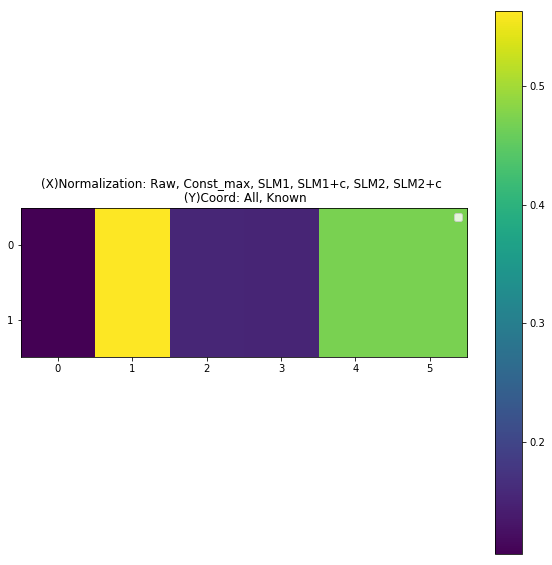

array([[0.10552369, 0.56343241, 0.15413321, 0.15232581, 0.47137366,
        0.4714504 ],
       [0.10553811, 0.56343215, 0.15413303, 0.152328  , 0.47137323,
        0.47145003]])

In [39]:
sensitivityPlot(['lstm_20'], [20], 1)